In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import os

In [2]:
def parseParameters(name):
    var_dict = {}

    param_tuple = name.split("__")

    for tuple in param_tuple:
        name, value = tuple.split("--")

        var_dict[name] = float(value)

    return var_dict


def generateCommand(struct_name, save="False"):
    params_str = struct_name.split("__")

    for i in range(len(params_str)):
        params_str[i] = params_str[i].replace("--", " ")
        params_str[i] = "--" + params_str[i]

    return " ".join(params_str) + " --s " + save

In [3]:
struct_name = "k--0.00001__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--5.0"

args_dict = parseParameters(struct_name)

k = args_dict["k"]
phi = args_dict["phi"]
ksi = args_dict["ksi"]
cb = args_dict["cb"]
C_nmax = args_dict["Cn_max"]
lambd_nb = args_dict["lambd_nb"]
mi_n = args_dict["mi_n"]
lambd_bn = args_dict["lambd_bn"]
y_n = args_dict["y_n"]
t_lower = args_dict["t_lower"]
t_upper = args_dict["t_upper"]

size_t = int(((t_upper - t_lower) / (k)))

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t = torch.arange(t_lower, t_upper, k, requires_grad=True).reshape(-1, 1)

t_cpu = t

Steps in time = 499999



In [6]:
os.system("python3 edo_fdm_model.py " + generateCommand(struct_name, save="True"))

True


0

In [5]:
with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'edo_fdm_sim/Cp__k--0.00001__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--5.0.pkl'

In [12]:
numpy_input = np.array([Cl, Cp]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = t.to(device)
    data_input = torch.tensor(numpy_input, dtype=torch.float32).to(device)

    print(device)

cuda


In [13]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [29]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [30]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](1, int(out_neurons)))

                else:
                    modules.append(nn.Linear(1, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [31]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [15]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [16]:
def pde(t, model):
    Cl, Cp = model(t).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    del dCl_dt
    del dCp_dt

    torch.cuda.empty_cache()

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [17]:
loss_fn = nn.MSELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
decay_rate = 0.99

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

n_epochs = 500
batch_size = 10000
C_pde_loss_it = torch.zeros(n_epochs).to(device)
C_data_loss_it = torch.zeros(n_epochs).to(device)
C_initial_loss_it = torch.zeros(n_epochs).to(device)
C_initial = initial_condition(t).to(device)

for epoch in range(n_epochs):
    for i in range(0, len(t), batch_size):
        t_initial = torch.zeros_like(t[i : i + batch_size])

        C_initial_pred = model(t_initial)

        loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

        C_pred = model(t[i : i + batch_size])

        loss_pde = loss_fn(
            pde(t[i : i + batch_size], model), torch.cat([t_initial, t_initial], dim=1)
        )

        loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

        loss = loss_initial + loss_pde + loss_data
        # loss = loss_initial + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    C_pde_loss_it[epoch] = loss_pde.item()
    C_initial_loss_it[epoch] = loss_initial.item()
    C_data_loss_it[epoch] = loss_data.item()

    if epoch % 100 == 0:
        print(f"Finished epoch {epoch}, latest loss {loss}")

Finished epoch 0, latest loss 0.009348421357572079
Finished epoch 100, latest loss 0.000296105194138363
Finished epoch 200, latest loss 0.00029492369503714144
Finished epoch 300, latest loss 0.0002926857559941709
Finished epoch 400, latest loss 0.0002902761334553361


In [18]:
pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

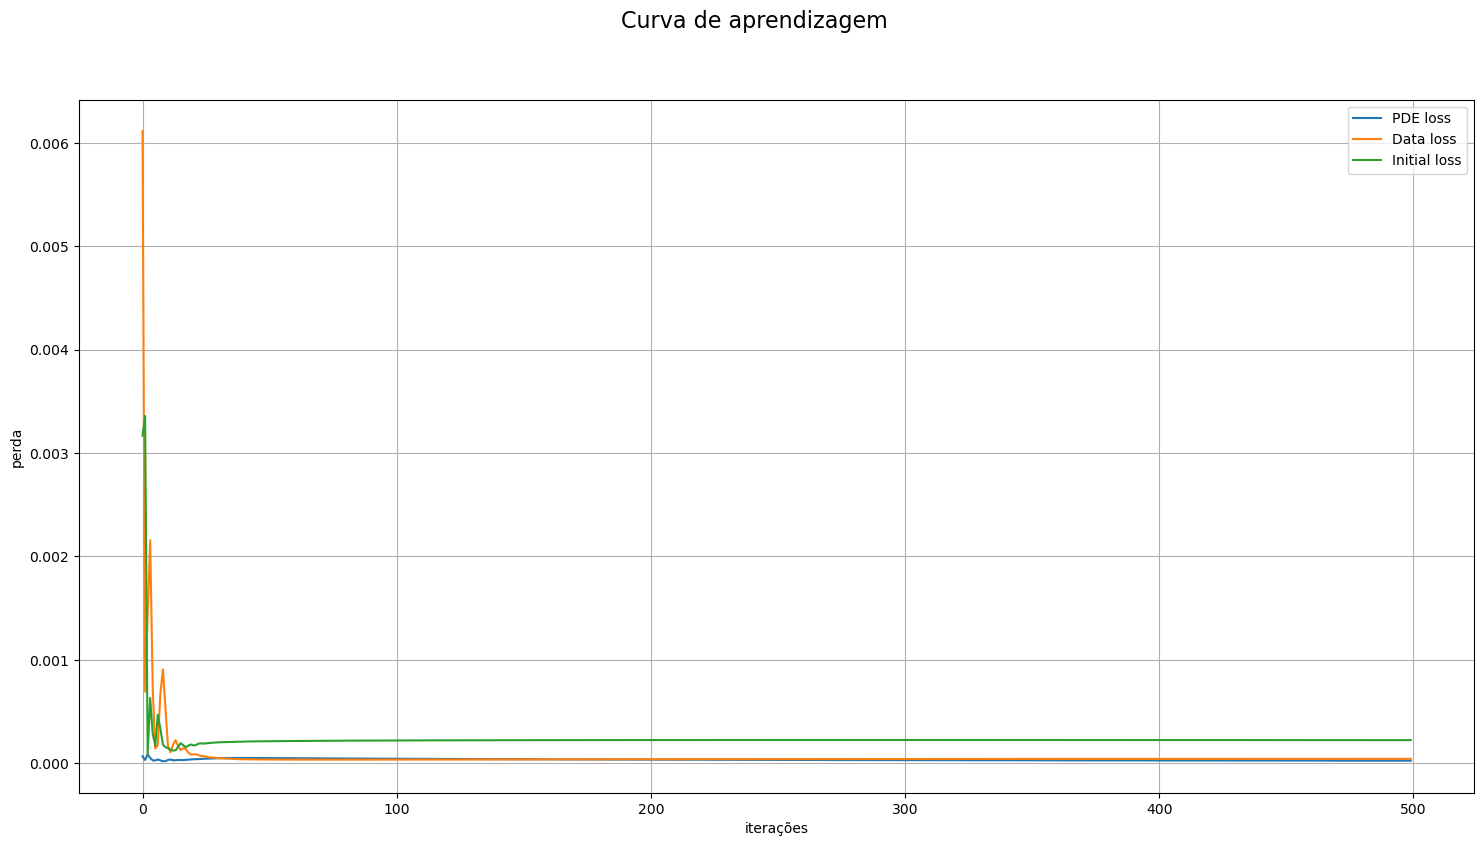

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.savefig("learning_curves/" + pinn_file + ".png")

In [20]:
model_cpu = model.to("cpu")

speed_up = []

for i in range(33):
    fdm_start = time.time()

    os.system("python3 edo_fdm_model.py " + generateCommand(struct_name, save="False"))

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(t_cpu).split(1, dim=1)

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [21]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p - Cl_f) ** 2 + (Cp_p - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(Cl_pinn, Cp_pinn, Cl, Cp)
    ]
)

max_ae = np.max(
    [
        [((Cl_p - Cl_f) ** 2) ** 0.5, ((Cp_p - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(Cl_pinn, Cp_pinn, Cl, Cp)
    ]
)

In [22]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [23]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.01991644
Erro absoluto máximo 0.03197691
Speed Up: 36.975665602199854 +/-31.217328224062133


In [24]:
with open("edo_pinn_sim/" + pinn_file + ".pkl", "wb") as f:
    pk.dump(output, f)

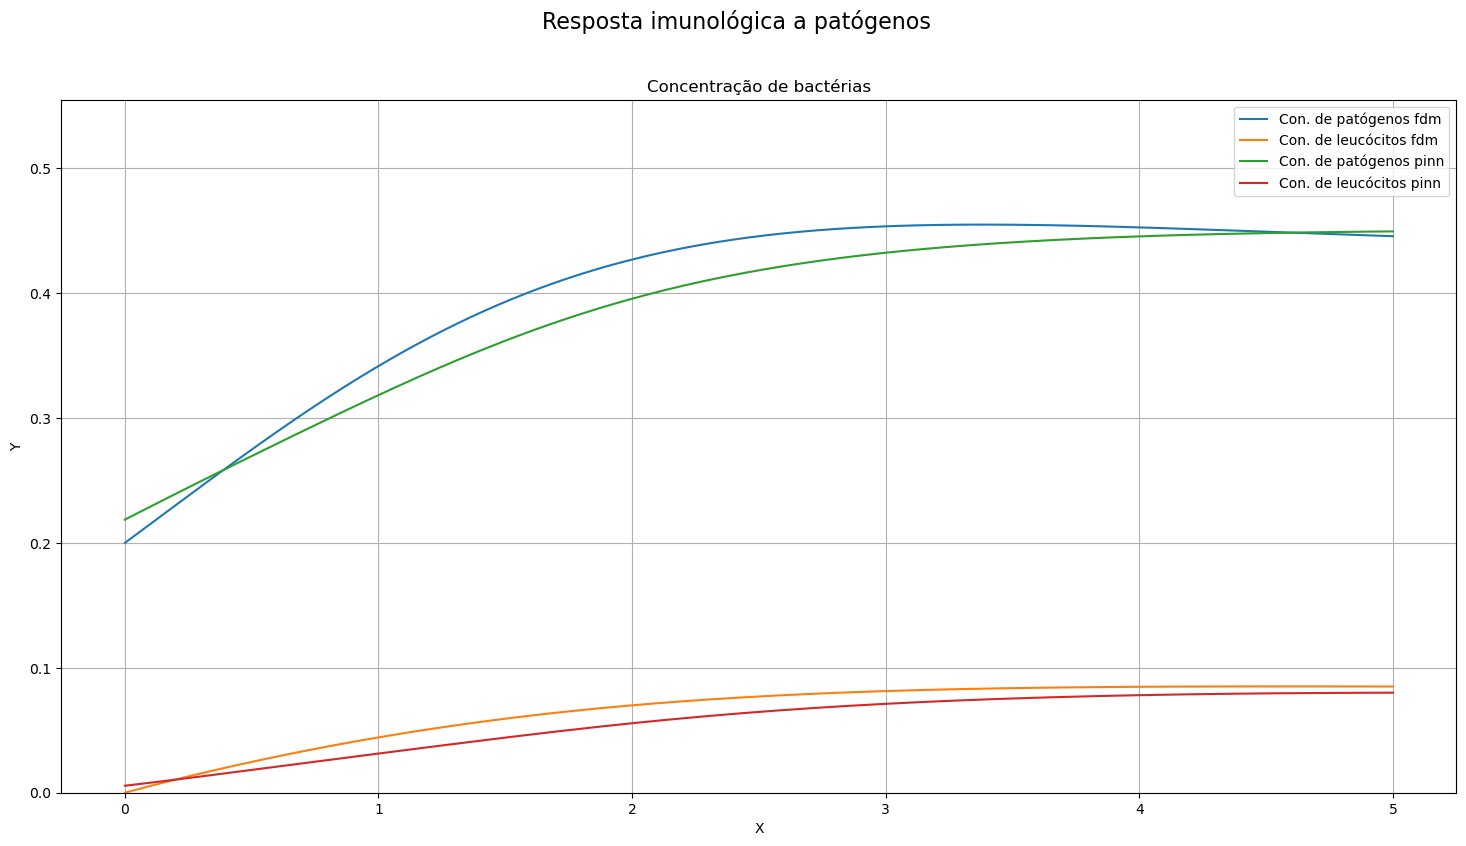

In [25]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max([np.max(Cl), np.max(Cp)])

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.plot(t_cpu.detach().numpy(), Cp, label="Con. de patógenos fdm")
ax.plot(t_cpu.detach().numpy(), Cl, label="Con. de leucócitos fdm")
ax.plot(t_cpu.detach().numpy(), Cp_pinn, label="Con. de patógenos pinn")
ax.plot(t_cpu.detach().numpy(), Cl_pinn, label="Con. de leucócitos pinn")
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

In [4]:
import glob

file_list = glob.glob("edo_pinn_sim/*")
file_list

['edo_pinn_sim/epochs_10000__batch_1000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_10000__batch_5000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_20000__batch_10000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_1000__batch_10000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_10000__batch_10000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_1000__batch_1000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_1000__batch_5000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_500__batch_10000__arch_Tanh--16__Tanh--16__Tanh--16__Linear--16.pkl']

In [61]:
import os
import glob
from itertools import product
import numpy as np


file = "k--0.0001__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0"
n_hd_layers = [1, 2]
n_neurons = [2**2, 2**3, 2**4]
activation_func = ["Elu", "LeakyReLU", "Sigmoid", "Tanh"]

batch_size = [(10000, 500), (5000, 1000)]

possible_layers = list(product(activation_func, n_neurons))

count = 0

# writing jobs

for n_l in n_hd_layers:
    layers_combinations = product(possible_layers, repeat=n_l)

    unique_l_comb = np.unique(layers_combinations)

    for layers_comb in product(possible_layers, repeat=n_l):
        arch_str = ""

        for layer in layers_comb:
            arch_str += layer[0] + "--" + str(layer[1]) + "__"

        for batch in batch_size:
            count += 1

In [62]:
count

312